<a href="https://colab.research.google.com/github/ptripathi/NLP/blob/master/models/model3/trainv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the encoder-decoder-attention model

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from __future__ import absolute_import, division, print_function

!pip install tensorflow-gpu==2.0.0-alpha0

In [0]:
import os
import sys
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

import re
import numpy as np
import os
import time
import pickle

In [4]:
print(tf.__version__)

2.0.0-alpha0


In [0]:
current_path = os.path.abspath(os.path.join('.'))
module_path = os.path.abspath(os.path.join('..'))

In [0]:
if module_path not in sys.path:
    sys.path.append(module_path)

In [0]:
import data_prep;
import utils;
import encoder;
import attention;
import decoder;

In [0]:
#dataset_save_location = "out/parallel.p"
dataset_save_location = "/content/gdrive/My Drive/W266/Project/data/parallel_trainv3.p"

In [9]:
X_all, Y_all, en_word2idx_all, en_idx2word_all, en_vocab_all, hi_word2idx_all, hi_idx2word_all, hi_vocab_all = utils.load_pickle_dataset(dataset_save_location)
len(X_all), len(Y_all), len(en_vocab_all), len(hi_vocab_all)

(696695, 696695, 50004, 50004)

In [0]:
emb_dim = 100

In [0]:
#embedding_weights = utils.load_glove_embeddings("../../data/glove.6B/", len(en_vocab_all), en_word2idx_all, emb_dim)

embedding_weights = utils.load_glove_embeddings("/content/gdrive/My Drive/W266/Project/data/glove.6B/", len(en_vocab_all), en_word2idx_all, emb_dim)

In [12]:
embedding_weights[en_word2idx_all['the']]

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [0]:
train_size = 40000
X = X_all[:train_size]
Y = Y_all[:train_size]

In [0]:
for n in range(len(X)):
  X[n] = [en_word2idx_all['<start>']] + X[n] + [en_word2idx_all['<end>']]
for n in range(len(X)):
  Y[n] = [hi_word2idx_all['<start>']] + Y[n] + [hi_word2idx_all['<end>']]

In [15]:
max_length_inp = utils.max_length(X)
max_length_tar = utils.max_length(Y)
(max_length_inp, max_length_tar)

(17, 17)

In [0]:
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(X,
                                                                maxlen=max_length_inp,
                                                                padding='post')
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(Y,
                                                                 maxlen=max_length_tar,
                                                                 padding='post')

In [0]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, shuffle=False, test_size=0.2)

In [18]:
for n in range(2):
    data_prep.printSentence(input_tensor_train[n], en_idx2word_all)
    print('\n')
    data_prep.printSentence(target_tensor_train[n], hi_idx2word_all)
    print('\n')

<start> select <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

<start> चुनें <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

<start> javascript enabled <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

<start> JavaScript सक्रिय <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 



In [19]:
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(32000, 32000, 8000, 8000)

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 100
units = 1024
vocab_inp_size = len(en_vocab_all)
vocab_tar_size = len(hi_vocab_all)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
from encoder import Encoder
from decoder import Decoder
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, weights_ = embedding_weights,mask=1)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = '/content/gdrive/My Drive/W266/Project/training_checkpoints_v3'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
# @tf.function: This annotation causes the function to be "compiled".
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
        
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([hi_word2idx_all['<start>']] * BATCH_SIZE, 1)       

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))
  
  return batch_loss

In [25]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for {} epoch {} sec\n'.format(epoch + 1, time.time() - start)) 

Epoch 1 Batch 0 Loss 4.1767
Epoch 1 Batch 100 Loss 1.7048
Epoch 1 Batch 200 Loss 1.6586
Epoch 1 Batch 300 Loss 1.7085
Epoch 1 Batch 400 Loss 1.6547
Epoch 1 Loss 1.8800
Time taken for 1 epoch 462.0125632286072 sec

Epoch 2 Batch 0 Loss 1.9610


KeyboardInterrupt: ignored

In [0]:
train_res_lines = train_results = open("train_results.txt", "r")

In [0]:
epoch_count = []
loss = []
for line in train_res_lines:
    if re.match("Epoch (\d+) Loss (.*)", line):
        epoch_count.append(line.split()[1])
        loss.append(line.split()[3])

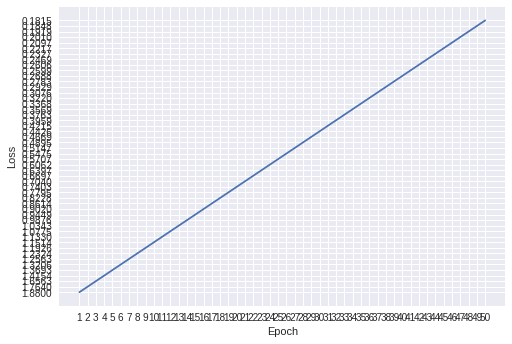

In [29]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoch_count, loss)